## Imports

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.io import wavfile # get the api
from pynq import Overlay 
import wave

## Define functions for getting wav data

In [44]:
def get_num_samples(wav):
    return wav.getnframes()
def get_num_channels(wav):
    return wav.getnchannels()
def get_sampling_frequency(wav):
    return wav.getframerate()
def get_duration(wav):
    return (get_num_samples(wav)/get_sampling_frequency(wav))
def get_bytes_per_sample(wav):
    return wav.getnchannels()
def print_wav_info(wav):
    #Print number of samples
    print("Number of samples", get_num_channels(wav))
    #Print number of channels (1--mono, 2--stereo)
    num_channels = wav.getnchannels()
    print("Number of channels", num_channels)
    #Print sampling frequency
    sampFreq = wav.getframerate()
    print("Sampling Frequency", sampFreq)
    #Print duration of file
    print("Duration of file (in s) ", get_duration(wav))
    #Print byte depth of audio (8-bit, 16-bit, etc.)
    print("bytes per sample", get_bytes_per_sample(wav))



## Get samples from wav file and plot sound data

Number of samples 2
Number of channels 2
Sampling Frequency 44100
Duration of file (in s)  5.616326530612245
bytes per sample 2


<IPython.core.display.Javascript object>


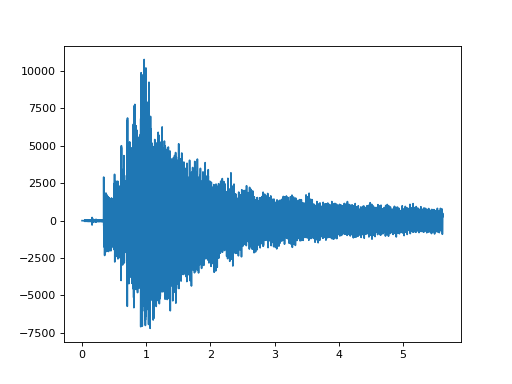

In [45]:
#This wav file consists of notes: E, B, G# -- corresponding to frequencies(in Hz): 82, 123, 208 
E7_chord = "../audio_files/E7_chord.wav"
#This wav file consist of one note: E -- corresponding to frequency(in Hz): 82
E_note = "../audio_files/lowE.wav"

#The following notebook can use either sound file -- try uncommenting either line to see the
#differences between their frequency spectrums
soundFile = E7_chord
#soundFile = E_note

#Open selected sound file and print metadata
wav = wave.open(soundFile)
print_wav_info(wav)

#Read samples into numpy array for easier manipulation
sampFreq, data = wavfile.read(soundFile)

#Get duration and number of samples
wav_duration = get_duration(wav)
num_samples = get_num_samples(wav)
#Create time axis to plot against sound data
t = np.linspace(0, wav_duration, num_samples)
#If stereo, convert to mono
if (get_num_channels(wav) == 2):
    data = data[:,0]

#Plot
fig, ax = plt.subplots() 
plt.plot(t, data)

## Define FFT functions

In [46]:
def get_FFT(data):
    #Only want real frequencies
    spectrum = np.fft.rfft(data)
    #Only want magnitude (intensity)
    abs_spectrum = np.abs(spectrum)
    return abs_spectrum

def get_frequency_vector(data, Fs):
    return np.fft.rfftfreq(data.size, d=1./Fs)

def get_frequency_window(samplingFrequency, freq_vector, max_desired_frequency):    
    max_given_frequency = samplingFrequency/2
    frequency_vector_length = len(freq_vector)
    
    if max_given_frequency < max_desired_frequency:
        print("Cannot plot desired window -- max frequency is ", max_given_frequency)
        return frequency_vector_length
    else:
        print("Cropping frequency window from available max ", max_given_frequency, "to desired max", max_desired_frequency)
        

    window_fraction = max_desired_frequency / max_given_frequency
    window = int(window_fraction * frequency_vector_length)
    return window
def plot_notebook(x, y, window):
    %matplotlib notebook
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(x[:window], y[:window])  # Plot some data on the axes.
def plot_fft(data):
    #Perform FFT on wav samples
    fft_spectrum_abs = get_FFT(data)

    #Generate frequency vector for plotting 
    freq = get_frequency_vector(data, sampFreq)
    
    #Calculates how many samples to display in order to see spectrum from [0, 500] Hz
    window = get_frequency_window(sampFreq, freq)
    
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(freq[:window], fft_spectrum_abs[:window])  # Plot some data on the axes.
def sample_wav_data(data, sampFreq, t0, t1, num_samples_desired):
    time_window = t1 - t0
    start_sample = t0 * sampFreq
    end_sample = t1 * sampFreq
    sample_window = end_sample - start_sample
    #Calculate space between selected wav samples
    stepSize = int(sample_window / num_samples_desired)
    #Create empty array to hold sampled data
    sampledData = np.zeros(num_samples_desired)
    
    #Fill sampled data array with "num_samples_desired" samples from wav file, spaced by "stepSize"
    for i in range(0, num_samples_desired):
        sampledData[i] = data[start_sample+(i*stepSize)]
    numSamplesObtained=len(sampledData)

    wav_sample_range = numSamplesObtained * stepSize
    wav_time_range = wav_sample_range / sampFreq
    newsampFreq = numSamplesObtained / wav_time_range
    
    print("Maximum frequency to be plotted is ", newsampFreq/2)
    
    return sampledData, newsampFreq


## Plot SW FFT based on wav-given Fs

Cropping frequency window from available max  22050.0 to desired max 500


<IPython.core.display.Javascript object>


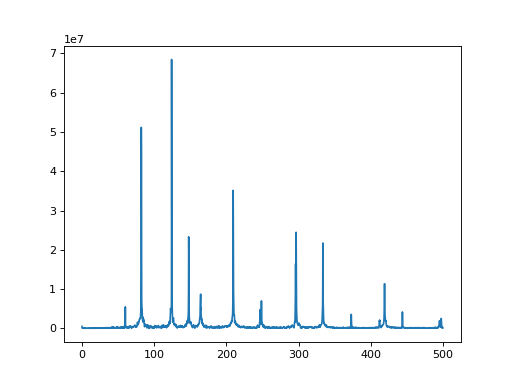

In [47]:
#Perform FFT on wav samples
fft_spectrum_abs = get_FFT(data)

#Generate frequency vector for plotting 
freq = get_frequency_vector(data, sampFreq)

#Calculates how many samples to display in order to see spectrum from [0, window_max]
window_max = 500
window = get_frequency_window(sampFreq, freq, window_max)

#Plot
plot_notebook(freq, fft_spectrum_abs, window)

## Sample data

In [6]:
#Create time and sample window
t0 = 0
t1 = 2
#t1 = wav_duration
numSamplesDesired = 16384

sampledData, newsampFreq = sample_wav_data(data, sampFreq, t0, t1, numSamplesDesired)

Maximum frequency to be plotted is  4410.0


Cropping frequency window from available max  4410.0 to desired max 500


<IPython.core.display.Javascript object>


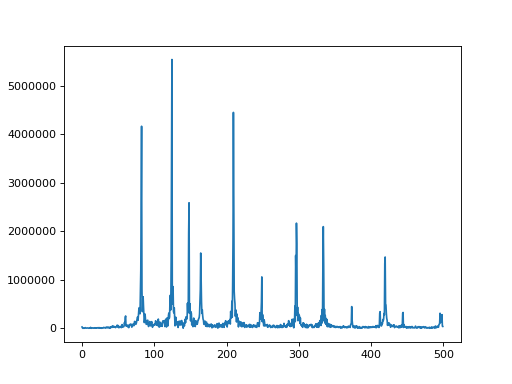

In [7]:
sampled_FFT_spectrum = get_FFT(sampledData)
sampled_frequency_vector = get_frequency_vector(sampledData, newsampFreq)
window_max = 500
window = get_frequency_window(newsampFreq, sampled_frequency_vector, window_max)
plot_notebook(sampled_frequency_vector, sampled_FFT_spectrum, window)

# Define Hardware Functions

In [105]:
from pynq import allocate
from pynq import Overlay

def hw_fft_postprocess(hw_output):
    #Only want to plot magnitude of hardware output
    fft_data = np.abs(hw_output)
    #Only interested in plotting positive frequencies
    max_pos_freq_index = len(fft_data) // 2 + 1
    pos_fft_data = fft_data[0:max_pos_freq_index]
    return pos_fft_data

def run_kernel():
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

# HW FFT with 1024 samples


In [106]:
overlay = Overlay("../Vivado_overlays/fft_1024/fft_1024.bit")
dma = overlay.fft_hier.axi_dma_0

In [107]:

t0 = 0
t1 = 1
fft_size = 1024

sampledData, newsampFreq_1024 = sample_wav_data(data, sampFreq, t0, t1, fft_size)

Maximum frequency to be plotted is  512.7906976744185


In [108]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [109]:
%timeit run_kernel()

1000 loops, best of 3: 605 µs per loop


Cropping frequency window from available max  512.7906976744185 to desired max 500


<IPython.core.display.Javascript object>


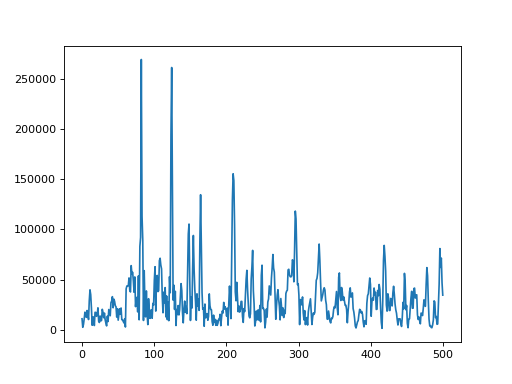

In [110]:
fft_data_1024 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_1024)
window_max = 500
window = get_frequency_window(newsampFreq_1024, freq, window_max)

plot_notebook(freq, fft_data_1024, window_max)

# HW FFT with 2048 samples


In [127]:
overlay = Overlay("../Vivado_overlays/fft_2048/fft_2048.bit")
dma = overlay.fft_hier.axi_dma_0

In [128]:
t0 = 0
t1 = 1
fft_size = 2048

sampledData, newsampFreq_2048 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  1050.0


In [129]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [130]:
%timeit run_kernel()

1000 loops, best of 3: 692 µs per loop


Cropping frequency window from available max  1050.0 to desired max 500


<IPython.core.display.Javascript object>


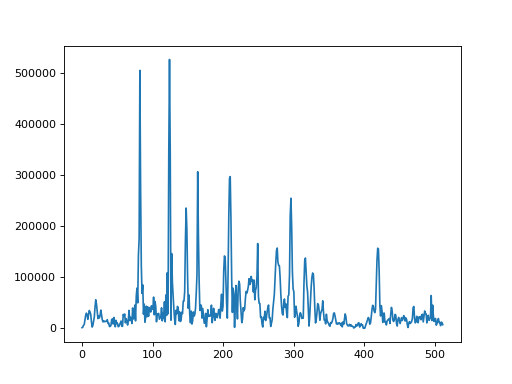

In [131]:
fft_data_2048 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_2048)
window_max = 500
window = get_frequency_window(newsampFreq_2048, freq, window_max)

plot_notebook(freq, fft_data_2048, window_max)

# HW FFT with 4096 samples

In [132]:
overlay = Overlay("../Vivado_overlays/fft_4096/fft_4096.bit")
dma = overlay.fft_hier.axi_dma_0

In [133]:
t0 = 0
t1 = 1
fft_size = 4096

sampledData, newsampFreq_4096 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  2205.0


In [134]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [135]:
%timeit run_kernel()

1000 loops, best of 3: 1.12 ms per loop


Cropping frequency window from available max  2205.0 to desired max 500


<IPython.core.display.Javascript object>


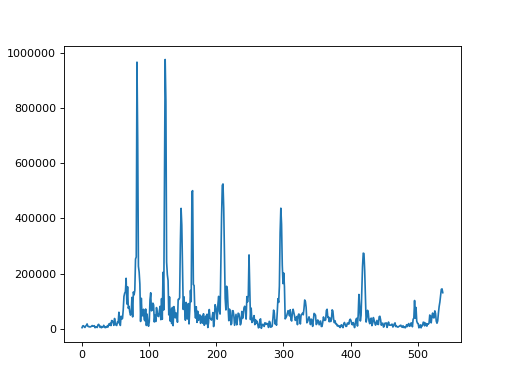

In [136]:
fft_data_4096 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_4096)
window_max = 500
window = get_frequency_window(newsampFreq_4096, freq, window_max)

plot_notebook(freq, fft_data_4096, window_max)

## HW FFT with 8192 samples

In [141]:
overlay = Overlay("../Vivado_overlays/fft_8192/fft_8192.bit")
dma = overlay.fft_hier.axi_dma_0

In [142]:
t0 = 0
t1 = 1
fft_size = 8192

sampledData, newsampFreq_8192 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  4410.0


In [143]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [144]:
%timeit run_kernel()

100 loops, best of 3: 2.09 ms per loop


Cropping frequency window from available max  4410.0 to desired max 500


<IPython.core.display.Javascript object>


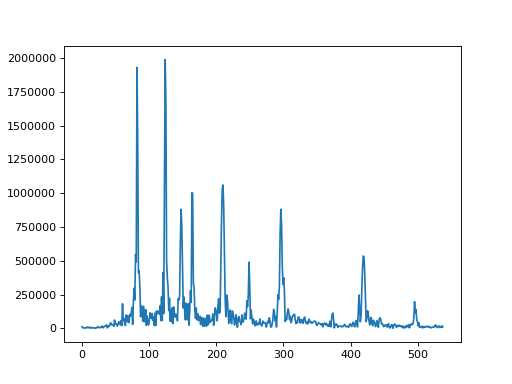

In [145]:
fft_data_8192 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_8192)
window_max = 500
window = get_frequency_window(newsampFreq_8192, freq, window_max)

plot_notebook(freq, fft_data_8192, window_max)

# HW FFT with 16384 samples

In [146]:
overlay = Overlay("../Vivado_overlays/fft_16384/fft_16384.bit")
dma = overlay.fft_hier.axi_dma_0

In [147]:
t0 = 0
t1 = 2
fft_size = 16384

sampledData, newsampFreq_16384 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  4410.0


In [148]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)
np.copyto(input_buffer, sampledData)

In [149]:
%timeit run_kernel()

100 loops, best of 3: 3.92 ms per loop


Cropping frequency window from available max  4410.0 to desired max 500


<IPython.core.display.Javascript object>


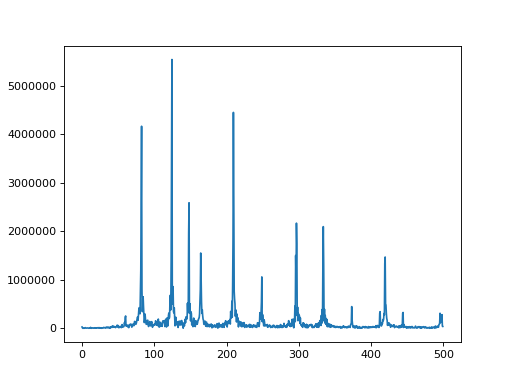

In [150]:
fft_data_16384 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_16384)
window_max = 500
window = get_frequency_window(newsampFreq_16384, freq, window_max)

plot_notebook(freq, fft_data_16384, window)

## Compare timing

In [151]:
#Software times

#NumPy FFT of entire wav file
%timeit get_FFT(data)

#NumPy FFT of 1024 samples from first 1s of audio
numSamplesDesired = 1024
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)


#NumPy FFT of 2048 samples from first 1s of audio
numSamplesDesired = 2048
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

#NumPy FFT of 4096 samples from first 1s of audio
numSamplesDesired = 4096
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

#NumPy FFT of 8192 samples from first 1s of audio
numSamplesDesired = 8192
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

#NumPy FFT of 16384 samples from first 1s of audio
numSamplesDesired = 16384
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

1 loop, best of 3: 276 ms per loop
Maximum frequency to be plotted is  512.7906976744185
1000 loops, best of 3: 570 µs per loop
Maximum frequency to be plotted is  1050.0
1000 loops, best of 3: 899 µs per loop
Maximum frequency to be plotted is  2205.0
1000 loops, best of 3: 1.57 ms per loop
Maximum frequency to be plotted is  4410.0
100 loops, best of 3: 3.27 ms per loop
Maximum frequency to be plotted is  11025.0
100 loops, best of 3: 6.68 ms per loop


In [ ]:
#See relevant hardware section to compare hardware times